In [1]:
from pyspark.sql import SparkSession
from operator import add
# spark://192.168.2.101:7077
# New API
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.101:7077") \
        .appName("Group12-project_2")\
        .config("spark.executor.cores",4)\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled", True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/24 21:48:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/24 21:48:27 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [2]:
# Old API (RDD)
spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")

In [3]:
data_frame = spark_session.read\
            .option("header", "true")\
            .json("hdfs://localhost:9000/user/ubuntu/project/RC_2010-02")\
            .cache()

In [4]:
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as f

In [5]:
data_frame.show(5)

+--------+----------+----------------------+-----------------+--------------------+----------------+-----------+-------------+-----+------+------+-------+--------+----------+----------+------------+-----+------------+----------+------------+---+
|archived|    author|author_flair_css_class|author_flair_text|                body|controversiality|created_utc|distinguished|downs|edited|gilded|     id| link_id|      name| parent_id|retrieved_on|score|score_hidden| subreddit|subreddit_id|ups|
+--------+----------+----------------------+-----------------+--------------------+----------------+-----------+-------------+-----+------+------+-------+--------+----------+----------+------------+-----+------------+----------+------------+---+
|    true|     norm_|                  null|             null|He is. Also, his ...|               0| 1264982400|         null|    0| false|     0|c0jr1nx|t3_aw8ym|t1_c0jr1nx|t1_c0jqo1t|  1426200887|   -5|       false|     Music|    t5_2qh1u| -5|
|    true|      

In [6]:
data_frame = data_frame.drop('author_flair_css_class', 'distinguished', 'author_flair_text', 'edited', 'gilded', 'link_id','parent_id', 'subreddit_id', 'removal_reason', 'name', 'id', 'archived', 'ups', 'created_utc', 'retrieved_on' )
data_frame.show(5)

+----------+--------------------+----------------+-----+-----+------------+----------+
|    author|                body|controversiality|downs|score|score_hidden| subreddit|
+----------+--------------------+----------------+-----+-----+------------+----------+
|     norm_|He is. Also, his ...|               0|    0|   -5|       false|     Music|
|      wh44|Well, certainly t...|               0|    0|    4|       false| AskReddit|
| karmanaut|[Here](http://img...|               0|    0|    4|       false| AskReddit|
|HeegeMcGee|Even with the new...|               0|    0|    3|       false|reddit.com|
|  ricemilk|Totally on the sa...|               0|    0|    1|       false|philosophy|
+----------+--------------------+----------------+-----+-----+------------+----------+
only showing top 5 rows



In [7]:
data_frame.sort(col("score")).show(30)

+-------------------+--------------------+----------------+-----+-----+------------+------------+
|             author|                body|controversiality|downs|score|score_hidden|   subreddit|
+-------------------+--------------------+----------------+-----+-----+------------+------------+
|            Saydrah|I upvoted you, bu...|               0|    0|-1845|       false|  reddit.com|
|   4Chan_Ambassador|So how long befor...|               0|    0| -472|       false|        pics|
|              Xhail|                Pics|               0|    0| -322|       false|        pics|
|              Xhail|God damn thats sexy.|               0|    0| -291|       false|        pics|
|WWWWWWWWWWWWWWWWWWW|THATS OVER 9000!!...|               0|    0| -268|       false|        pics|
|            Saydrah|I'm not going to ...|               0|    0| -227|       false|  reddit.com|
|        powerdeamon|You know what, my...|               0|    0| -218|       false|        pics|
|          [deleted]

In [8]:
reddit_contro = data_frame.drop('downs')

In [9]:
reddit_contro.orderBy(col("controversiality").desc(), col("score").asc()).show(30)

+-------------------+--------------------+----------------+-----+------------+------------+
|             author|                body|controversiality|score|score_hidden|   subreddit|
+-------------------+--------------------+----------------+-----+------------+------------+
|            Saydrah|I upvoted you, bu...|               0|-1845|       false|  reddit.com|
|   4Chan_Ambassador|So how long befor...|               0| -472|       false|        pics|
|              Xhail|                Pics|               0| -322|       false|        pics|
|              Xhail|God damn thats sexy.|               0| -291|       false|        pics|
|WWWWWWWWWWWWWWWWWWW|THATS OVER 9000!!...|               0| -268|       false|        pics|
|            Saydrah|I'm not going to ...|               0| -227|       false|  reddit.com|
|        powerdeamon|You know what, my...|               0| -218|       false|        pics|
|          [deleted]|           [deleted]|               0| -217|       false|  

In [10]:
#Are most of the downvoted comments created by the same author?
negativ = reddit_contro.filter(col("score") < 0)
num_negativ = negativ.count()
# Controversial comments count
negativ_names = negativ.filter(reddit_contro.body != "[deleted]")
negativ_names.show(5)

+--------------+--------------------+----------------+-----+------------+-----------+
|        author|                body|controversiality|score|score_hidden|  subreddit|
+--------------+--------------------+----------------+-----+------------+-----------+
|         norm_|He is. Also, his ...|               0|   -5|       false|      Music|
|      Asystole|WHAT. Are you ser...|               0|   -5|       false|     gaming|
|      hydropsy|Also see the whit...|               0|   -2|       false|   politics|
|BabylonDrifter|1.  Agreed, but i...|               0|   -7|       false|environment|
|     [deleted]|Several of the po...|               0|   -5|       false|Libertarian|
+--------------+--------------------+----------------+-----+------------+-----------+
only showing top 5 rows



In [11]:
author = negativ_names.groupBy('author').count()
author.sort(col("count").desc()).show(20)

+---------------+-----+
|         author|count|
+---------------+-----+
|      [deleted]|23586|
|       BlueRock|  470|
|    insomniac84|  322|
|       angryboy|  295|
|  disinforeddit|  266|
|        selwonk|  236|
|     AnnArchist|  227|
|     malcontent|  198|
|     moonflower|  189|
|        MrOhHai|  147|
|Palin_Beck_2012|  137|
|         matts2|  137|
| Confucius_says|  133|
|    StoneCypher|  127|
|      pitofdoom|  127|
|NoMoreNicksLeft|  122|
|          daysi|  121|
|      thedude37|  120|
|     punterjohn|  107|
|    eaturbrainz|  106|
+---------------+-----+
only showing top 20 rows



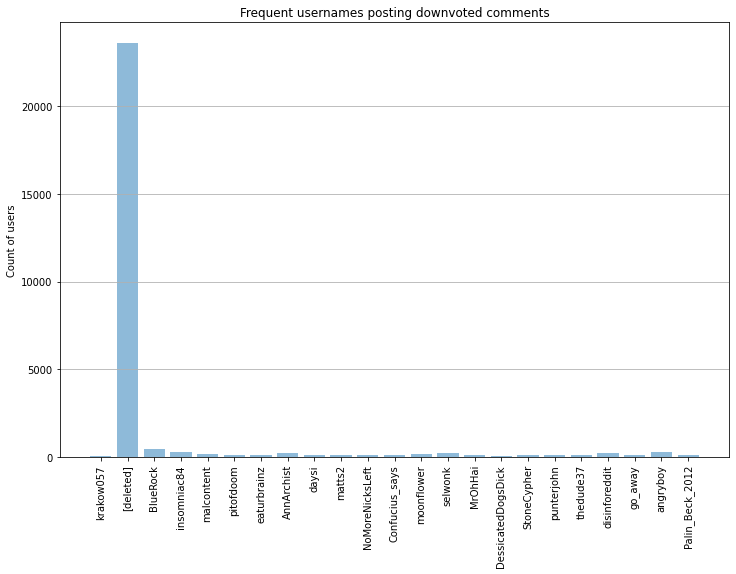

In [12]:
author = author.filter(col("count") > 99)
author = author.filter(author.author != "")

# Create arrays for the plot
author2 = author.select('author').rdd.flatMap(lambda x: x).collect()
x_pos = np.arange(len(author2))
occ = author.select('count').rdd.flatMap(lambda x: x).collect()

#build the plot
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x_pos, occ, align='center', alpha=0.5)
ax.set_ylabel('Count of users')
ax.set_xticks(x_pos)
ax.set_xticklabels(author2, rotation='vertical')
ax.set_title('Frequent usernames posting downvoted comments')
ax.yaxis.grid(True)
plt.show()

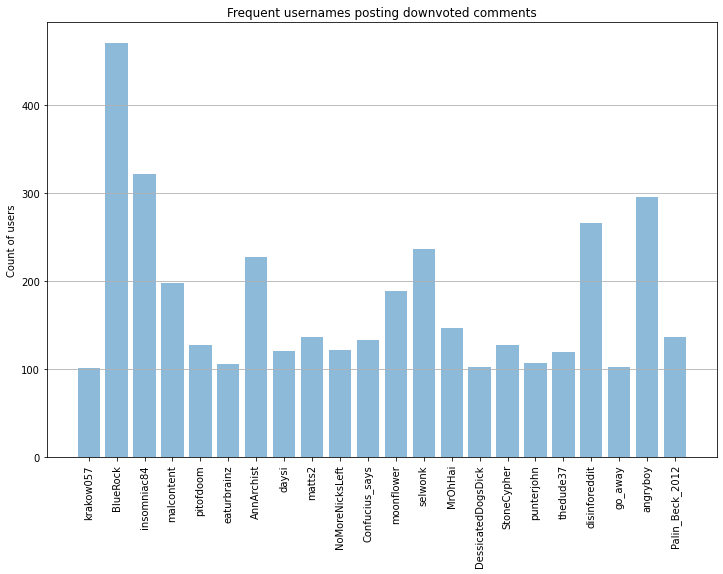

In [13]:
# Now if we remove "[deleted]".
author = author.filter(author.author != "[deleted]")

# Create arrays for the plot
author2 = author.select('author').rdd.flatMap(lambda x: x).collect()
x_pos = np.arange(len(author2))
occ = author.select('count').rdd.flatMap(lambda x: x).collect()

#build the plot
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x_pos, occ, align='center', alpha=0.5)
ax.set_ylabel('Count of users')
ax.set_xticks(x_pos)
ax.set_xticklabels(author2, rotation='vertical')
ax.set_title('Frequent usernames posting downvoted comments')
ax.yaxis.grid(True)
plt.show()

In [14]:
# Count of controversial comments
controversial = reddit_contro.filter(reddit_contro.controversiality == 1)
num_contro = controversial.count()
print(f'Out of {data_frame.count()} comments, {num_contro} were classified as controversial')
#print(data_frame.count())

# Count negative comments
print(f'Out of {data_frame.count()} comments, {num_negativ} were down voted')


Out of 2687779 comments, 0 were classified as controversial
Out of 2687779 comments, 132657 were down voted


In [15]:
#Do negative comments gain the same amount of score as “regular” comments?
# noncontroversial = reddit_contro.filter(reddit_contro.controversiality == 0)
positive = reddit_contro.filter(col("score") > -1)
# Number of down voted comments
num_neg = negativ.count()
# Number of up voted or neutral comments comments
num_pos = positive.count()




# Avrage score for contro comments and non contro comments
# Num cont score/num cont comments
score_pos = positive.agg({'score': 'sum'}).collect()[0][0] 
avg_pos = score_pos/num_pos


# Num non cont score/num non cont comments
score_neg = negativ.agg({'score': 'sum'}).collect()[0][0]

avg_neg = score_neg/num_neg

print(f'The total score for the downvoted comments were {score_neg}')
print(f'The total score for the upvoted comments were {score_pos}')
print(f'The avrage score for upvoted comments is: {avg_pos}')
print(f'The avrage score for downvoted comments is: {avg_neg}')


The total score for the downvoted comments were -515436
The total score for the upvoted comments were 11592492
The avrage score for upvoted comments is: 4.536962227243944
The avrage score for downvoted comments is: -3.885479092697709


Text(0.5, 1.0, 'Distribution up/down voted comments')

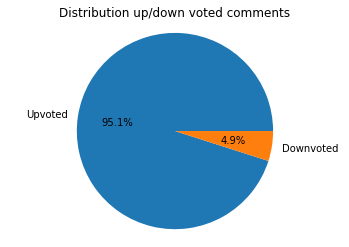

In [16]:

%matplotlib inline

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Upvoted', 'Downvoted']
sizes = [num_pos, num_neg]


fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Distribution up/down voted comments')

In [17]:
#What subreddits (according to this data) is considered to be have more downvoted comments?
subreddits = negativ.groupBy('subreddit').count()
subreddits.sort(col("count").desc())
subreddits.show(20)

+-----------------+-----+
|        subreddit|count|
+-----------------+-----+
|       MensRights|  587|
|            anime|   37|
|            scifi|  314|
|           hockey|  108|
|        australia|  147|
|        chemistry|    2|
|              PS3|   87|
|            space|  151|
|        Marijuana|  167|
|           iphone|   42|
|    Documentaries|   12|
|        AskReddit|20844|
|           videos| 1270|
|ideasfortheadmins|   17|
|            4chan|   62|
|            Drugs|  185|
|       web_design|  297|
|        feminisms|   97|
|          chicago|    8|
|            shill|    3|
+-----------------+-----+
only showing top 20 rows



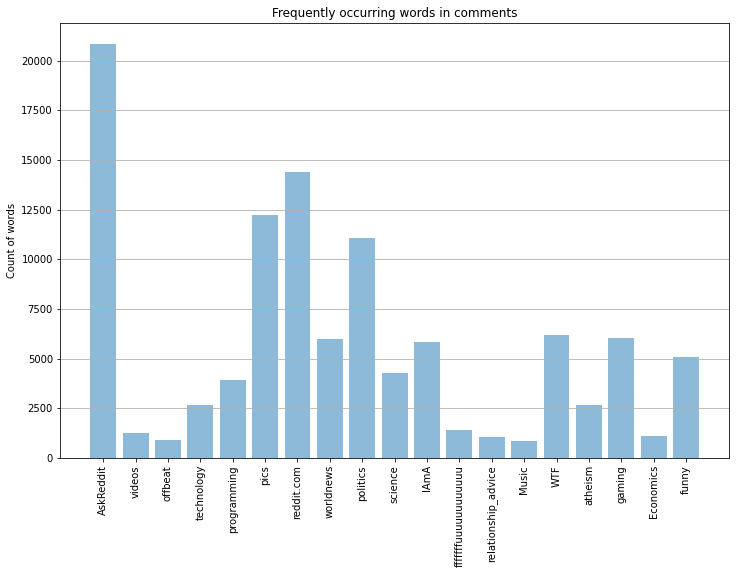

In [18]:
subreddits = subreddits.filter(col("count") > 800)
subreddits = subreddits.filter(subreddits.subreddit != "")
# Create arrays for the plot
sub = subreddits.select('subreddit').rdd.flatMap(lambda x: x).collect()
x_pos = np.arange(len(sub))
sub_occ = subreddits.select('count').rdd.flatMap(lambda x: x).collect()

#build the plot
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x_pos, sub_occ, align='center', alpha=0.5)
ax.set_ylabel('Count of words')
ax.set_xticks(x_pos)
ax.set_xticklabels(sub, rotation='vertical')
ax.set_title('Frequently occurring words in comments')
ax.yaxis.grid(True)
plt.show()

In [19]:
#What keywords are often used in controversial comments?

words = negativ.drop('author', 'controversiality', 'score', 'subreddit', 'score_hidden')
words.show(5)

+--------------------+
|                body|
+--------------------+
|He is. Also, his ...|
|           [deleted]|
|WHAT. Are you ser...|
|Also see the whit...|
|1.  Agreed, but i...|
+--------------------+
only showing top 5 rows



In [20]:
# count words for each comment.
words = words.withColumn('wordCount', f.size(f.split(f.col('body'), ' ')))
words.show()

+--------------------+---------+
|                body|wordCount|
+--------------------+---------+
|He is. Also, his ...|       92|
|           [deleted]|        1|
|WHAT. Are you ser...|       52|
|Also see the whit...|       52|
|1.  Agreed, but i...|      114|
|Several of the po...|       57|
|  Not drinking.  ;-)|        4|
|Just learn HTML i...|       62|
|women are manipul...|       12|
|I preferred the [...|        9|
|           [deleted]|        1|
|           [deleted]|        1|
|           [deleted]|        1|
|           [deleted]|        1|
|would women like ...|       14|
|           [deleted]|        1|
|Yeah, stellar ref...|       18|
|I get it - becaus...|       29|
|           [deleted]|        1|
|Says the guy who ...|       11|
+--------------------+---------+
only showing top 20 rows



In [21]:
# Count instance of word occurring
words = words.withColumn('word', f.explode(f.split(f.col('body'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)
words.show(5)

+----+------+
|word| count|
+----+------+
| the|140507|
|  to|102316|
|   a| 90107|
|    | 79191|
|  of| 73750|
+----+------+
only showing top 5 rows



In [22]:
words2 = words.filter(col("count") > 5000)
words2 = words2.filter(words2.word != "")
words2.show()

+----+------+
|word| count|
+----+------+
| the|140507|
|  to|102316|
|   a| 90107|
|  of| 73750|
| and| 72251|
|  is| 60617|
|   I| 59781|
| you| 58315|
|that| 54295|
|  in| 43337|
|  it| 35208|
| for| 32820|
| are| 28857|
| not| 26811|
|have| 25000|
|  be| 24429|
|  on| 22823|
|with| 22473|
|this| 20108|
|your| 19934|
+----+------+
only showing top 20 rows



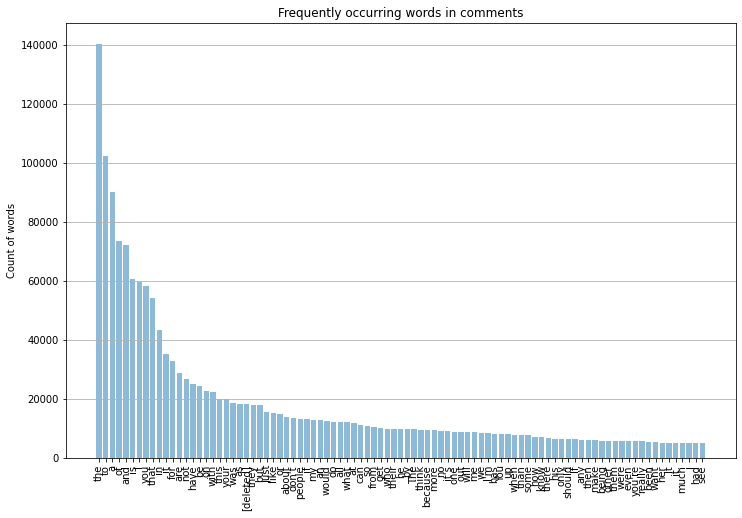

In [23]:
# Create arrays for the plot
words3 = words2.select('word').rdd.flatMap(lambda x: x).collect()
x_pos = np.arange(len(words3))
counts = words2.select('count').rdd.flatMap(lambda x: x).collect()

#build the plot
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x_pos, counts, align='center', alpha=0.5)
ax.set_ylabel('Count of words')
ax.set_xticks(x_pos)
ax.set_xticklabels(words3, rotation='vertical')
ax.set_title('Frequently occurring words in comments')
ax.yaxis.grid(True)


# Save the figure and show
#plt.tight_layout()
#plt.savefig('words_bar_plot.png')
plt.show()

In [24]:
# release the cores for another application!
spark_context.stop()